## ARSET OCO-3 data map and plots using OpenDAP and XCO2 variability in Select Urban Areas

For test purposes only.

The dataset used in this notebook is the <b> OCO-3 L2 Full Physics (FP)</b> files that are archived at the GES-DISC ([click here for details](https://disc.gsfc.nasa.gov/datasets/OCO3_L2_Lite_FP_10.4r/summary?keywords=OCO3_L2_Lite_FP_10.4r)) and in NetCDF Format.

The code interacts with an OpenDAP (Open-source Project for a Network Data Access Protocol) server, retrieves data, preprocess it, and then visualize the extracted datasets. ([Access OpenDAP](https://oco2.gesdisc.eosdis.nasa.gov/opendap)). OPENDAP is a protocol that enables remote access to scientific data, often used in environmental and climate science. PYDAP is a Python library that facilitates data retrieval from OPENDAP servers, making it easier to access and work with remote datasets.

**Note**: A .netrc file containing an individual user's **NASA Earthdata Login** credentials (not supplied with this notebook) should be provided by each user intending to operate this notebook from their own AWS cloud environment. Below are the steps to creating a .netrc file:

1. Create an **Earthdata Login Account** ([clear here for details](https://urs.earthdata.nasa.gov/users/new))
2. Approve access to the **NASA GES DISC Archive** in your Earthdata Login Profile ([click here for details](https://disc.gsfc.nasa.gov/earthdata-login))
3. Create/modify a **.netrc** file in your home directory containing your **Earthdata Login** credentials as shown below:
   <br>`machine urs.earthdata.nasa.gov login <your username> password <your password>`


### Notebook author(s)/Affiliation
Karen Yuen (karen.yuen@jpl.nasa.gov), Sagar Limbu (UC Berkeley), Charles Thompson (charles.k.thompson@jpl.nasa.gov), David F. Moroni  (david.f.moroni@jpl.nasa.gov) / Jet Propulsion Laboratory, Californa Institute of Technology

### Date Authored
June 13, 2024

### Collaborator/Affiliation
Abhishek Chatterjee/Jet Propulsion Laboratory, Californa Institute of Technology

### Acknowledgements

This notebook is only meant for initial training and demonstration of the utility of these datasets in support of the OCO-2/OCO-3 Applied Remote Sensing Training (ARSET).

This notebook is designed to function "as-is" for the scope of the training exercise; as code dependencies and data sources periodically become deprecated or updated, the users of these notebooks bear the responsibility to maintain and/or repurpose these notebooks and associated dependencies in a workable state beyond scope of initial training.This notebook was produced to support the OCO-2/OCO-3 Applied Remote Sensing Training (ARSET) training session. For full details, please refer to ([ARSET Applications of CO2 for Climate related studies](https://appliedsciences.nasa.gov/get-involved/training/english/arset-applications-carbon-dioxide-measurements-climate-related)).


### 1. Let's begin by importing the libraries you need to set up the environment

In [1]:
## Preprocessing: retrieve data from netCDF and convert to pandas columns

import netCDF4 # packages to open 'netcdf' file
import numpy as np # numpy and pandas packages to pre-process the dataset
import pandas as pd

# Data access from OPENDAP source

from urllib import request, parse
import getpass
import netrc
import os
import requests
import os
import time
from netCDF4 import Dataset

# pydap library to open session
from pydap import client
from pydap.cas.urs import setup_session
from pydap.client import open_url

import json

# For visualization and plotting
import matplotlib.pyplot as plt # to create plots and graphs
from mpl_toolkits.basemap import Basemap # to create geo-spatial map, requires dependencies installation
import plotly.express as px
import matplotlib.patches as mpatches
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib.collections import PatchCollection
import time
import matplotlib

import lxml
import html5lib

# To load webcontent and retrieve data from link
from IPython.display import display, HTML
from IPython import display
from datetime import datetime

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Cleaning
import gc
import sys

# Web Scrap for the contents
import re

# To grab data from entire year, month
from bs4 import BeautifulSoup # 

## GEOPY package to locate the region
from geopy.geocoders import Nominatim
import geopy

### 2. Earth Access Log-in (If you follow environment set up procedure from Lesson 2, you will automatically be logged in here)


In [2]:
def get_session(url, file_name):
    """
    Creating a session with url and filename in openDap for data retrieval
    https://oco2.gesdisc.eosdis.nasa.gov/opendap/
    """
    print('inside get_session\n')
    print(file_name)
    try:
##        login_credentials= 'uat.urs.earthdata.nasa.gov'
        login_credentials= 'urs.earthdata.nasa.gov'
        username, _, password = netrc.netrc().authenticators(login_credentials)
        print(username)
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print('\n*******************************************\n')
        print('Please provide your Earthdata Login credentials to allow data access\n')
        print('Your credentials will only be passed to %s and will not be exposed in Jupyter' % (url))
        print('\n')
        username = input('Username: ')
        password = getpass.getpass()
        print('\n*******************************************\n')
        
    # pydap session
    print(url + file_name)
    session = setup_session(username, password, check_url= url + file_name)
    
    # using the session to get access the data
    return session

### 3. Selection input for our chosen area(s). Once you have made the selections (see input notes), go to next cell and click run.

In [3]:
%%time
print("OCO3 currently has -> 10 vr.\n")
## Input to select year and data version
## For year, enter 2021, for month, enter 06 (not just "6"). For version, enter 10
## After the files are retrieved, click on the next cell below to continue the run.

year= input("Enter the Year: ")
month= input("Enter the Month: ")
ver_= input("Enter the version: ")

## FORMAT the filenames by VERSION and YEAR
## RETRIEVE all filenames for the YEAR using webscraping 
## OCO3
lite_file= '/OCO3_L2_Lite_FP.'+ str(ver_)+ '.4r' +'/'+ year 

########################################################################
# GET THE files from OpenDap source. Open the netcdf file and store in dataframe
# Beautiful soup to retrieve all data for the input time period 
########################################################################

main_url='https://oco2.gesdisc.eosdis.nasa.gov/opendap'
content= '/contents.html'

s= requests.get(main_url + lite_file + content)

## Scrap the content by specified URL
## Get the entire filenames of the searched YEAR
soup= BeautifulSoup(s.content, 'html.parser')

list_files=[]
## regex expression to GET netCDF files
html_links= soup.select('a[href$=".nc4.html"]')

for link in html_links:
    list_files.append(link['href'])

## pre-process the filenames; strings, CLEAN the files
# removing last strings '.html' to download the files from PYDAP library to match file names
files_oco2= [f[:-5] for f in list_files]

# total_files= ['opendap'+lite_file+'/'+ f for f in files_oco2[:3]]
total_files= [lite_file+'/'+ f for f in files_oco2]

## get alternate row files; duplicate ROWS on html LINKS
total_files= total_files[::2]

## print(total_files)

OCO3 currently has -> 10 vr.



Enter the Year:  2021
Enter the Month:  06
Enter the version:  10


CPU times: user 612 ms, sys: 94.9 ms, total: 707 ms
Wall time: 18.8 s


### 4. Go to OpenDAP source to access files
- https://oco2.gesdisc.eosdis.nasa.gov/opendap

In [4]:
url=main_url

print(main_url)
print(total_files[0])

https://oco2.gesdisc.eosdis.nasa.gov/opendap
/OCO3_L2_Lite_FP.10.4r/2021/oco3_LtCO2_210101_B10400Br_220318005017s.nc4


In [5]:
session= get_session(url, total_files[0])

inside get_session

/OCO3_L2_Lite_FP.10.4r/2021/oco3_LtCO2_210101_B10400Br_220318005017s.nc4
kyuen_rogez.69
https://oco2.gesdisc.eosdis.nasa.gov/opendap/OCO3_L2_Lite_FP.10.4r/2021/oco3_LtCO2_210101_B10400Br_220318005017s.nc4


In [6]:
len(total_files)

338

In [7]:
## Get files for Searched year and month
### File format on OpenDAP server: `'/OCO3_L2_Lite_FP.10.4r/2020/oco3_LtCO2_20'`

In [8]:
%%time
## string char capture OCO file and specific month '[0][:41] + month 
## string char capture OCO file and year only '[0][:41]'
total_= [f for f in total_files if f.startswith(total_files[0][:41] + month) ]

CPU times: user 174 μs, sys: 1 μs, total: 175 μs
Wall time: 179 μs


### 5. Preparation for plotting based on 15 day cycle periods for the time period searched (the longer the time range, the more files you will access = longer wait time).

In [9]:
## total_= total_[:15]
len(total_)

30

### 6. Perform iterative process to access and retrieve multiple files (get pydap data and appends all the variables together)

In [10]:
%%time
# session.post

##Let all files get processed before proceeding, each one takes a few seconds to process. 

## list of pydap variables
xco2=[]
long_vertices=[]
lat_vertices=[]
sounding_id=[]
qual_flag=[]


if session:
#     print("alive")
    for j in range(0, len(total_)):
        print('====================================')
        print(main_url + total_[j])
        print('====================================')
        pydap_df= open_url(main_url + total_[j], session=session)
        print(pydap_df.attributes.keys)

        #################################################
        # collect the data
        xco2.append(np.array(pydap_df["xco2"][:]))
        long_vertices.append(pydap_df["vertex_longitude"][:])
        lat_vertices.append(pydap_df["vertex_latitude"][:])
        qual_flag.append(pydap_df["xco2_quality_flag"][:])
#        sounding_id.append(pydap_df["date"])        

        print('***********************/n')
else:
    print("request new session")

https://oco2.gesdisc.eosdis.nasa.gov/opendap/OCO3_L2_Lite_FP.10.4r/2021/oco3_LtCO2_210601_B10400Br_220318011131s.nc4
<built-in method keys of dict object at 0x13c582b40>
***********************/n
https://oco2.gesdisc.eosdis.nasa.gov/opendap/OCO3_L2_Lite_FP.10.4r/2021/oco3_LtCO2_210602_B10400Br_220318011151s.nc4
<built-in method keys of dict object at 0x13c5b0f80>
***********************/n
https://oco2.gesdisc.eosdis.nasa.gov/opendap/OCO3_L2_Lite_FP.10.4r/2021/oco3_LtCO2_210603_B10400Br_220318011157s.nc4
<built-in method keys of dict object at 0x13c5ecfc0>
***********************/n
https://oco2.gesdisc.eosdis.nasa.gov/opendap/OCO3_L2_Lite_FP.10.4r/2021/oco3_LtCO2_210604_B10400Br_220318011208s.nc4
<built-in method keys of dict object at 0x13c56d980>
***********************/n
https://oco2.gesdisc.eosdis.nasa.gov/opendap/OCO3_L2_Lite_FP.10.4r/2021/oco3_LtCO2_210605_B10400Br_220318011232s.nc4
<built-in method keys of dict object at 0x13c5d9940>
***********************/n
https://oco2.gesdisc

'********************************************************'

## 7. Pre-process the data
1. Pandas dataframe: filter the data by quality-flag-> 0
2. Dstack the vertices from CORNER points
3. Create Polygon PATCHES from matplotlib

In [11]:
%%time
##################################################
# 1. Create pandas dataframe to filter the values

df_oco3= pd.DataFrame()
df_oco3["Xco2"]= np.array(np.concatenate(xco2)).ravel() 
df_oco3["Longitude_vertices"]= list(np.array(np.concatenate(long_vertices)))
df_oco3["Latitude_vertices"]= list(np.array(np.concatenate(lat_vertices)))
df_oco3["quality_flag"]= np.array(np.concatenate(qual_flag)).ravel()

del xco2
del long_vertices
del lat_vertices
del qual_flag
gc.collect()

##################################################
# Filter the DATA by quality flag-> 0
df_oco3= df_oco3[df_oco3["quality_flag"]== 0]
df_oco3=df_oco3.reset_index()
df_oco3= df_oco3.drop(columns=["index"])

#################################################
# 2. DSTACK the vertices of corner points together
flat_vertices=[]
for j in range(0, len(df_oco3)):
    flat_vertices.append(np.dstack([df_oco3["Longitude_vertices"].iloc[j], df_oco3["Latitude_vertices"].iloc[j] ]))

##################################################
# 3. GET patches from the vertices
## unpack the values from the list
unpack_vertices= [elem for sublist in flat_vertices for elem in sublist]
patches_total= [mpatches.Polygon(row) for row in unpack_vertices]

##################################################
## XCO2 values
xco2_total= df_oco3["Xco2"][:]

## Garbage Collect, release memory
del df_oco3
gc.collect()

CPU times: user 1min 59s, sys: 4.56 s, total: 2min 4s
Wall time: 2min 4s


0

## 8. PLOT with Basemap using the vertices

In [12]:
# %matplotlib notebook

In [13]:
"""
1. Pass the xco2 values and Patches values generated from POLYGON shape
2. Use either `Dark` or `ArcGis` Theme
3. Pass the bounding box information
4. Pass OFFSet points for map to visuzlize a bit extent outside the actual MAP
5. Pass the location string
6. Pass the YEAR and MONTH from previous search criteria to OPENDAP
"""
def plot_vertices(xco2_data, patches, bbx_list_info, location, year, month):
    # ## XCO2 values
    # xco2_total= xco2_list

    ## plot to graph using basemap
    fig= plt.figure(111)
    ax= fig.add_subplot(111)

    ## You can set the MIN and MAX boundaries for XCO2
    xco2_min_= 405
    xco2_max_= 425

    # world map: 
    # set the boundaries
#     llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat= -180, 90, -90, 90 
    
    
##   Pass OFFSet points for map to visuzlize a bit extent outside the actual MAP
    offset= 1
    llcrnrlon= bbx_list_info[2] - offset
    urcrnrlon= bbx_list_info[3] + offset
    llcrnrlat= bbx_list_info[0] - offset
    urcrnrlat= bbx_list_info[1] + offset
    
    # ###worldmap (FULL_OUTER_MAP)
    m= Basemap(projection= 'cyl',
            llcrnrlon= llcrnrlon,
            urcrnrlon= urcrnrlon,
            llcrnrlat= llcrnrlat,
            urcrnrlat= urcrnrlat,   
            resolution='l', 
            epsg= 4269
            )

    ## DARK theme map (you can choose any theme based on your preference from the library)
    # m.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
    # m.drawmapboundary(fill_color='#000000') 

    ### ArcGIS map
    m.arcgisimage(server='http://server.arcgisonline.com/ArcGIS', 
                  #service='World_Shaded_Relief', 
                  service='World_Imagery',
                  xpixels=2000, ypixels=None, dpi= 2000, verbose=False)


    cmap= plt.get_cmap('viridis')
    colors= cmap(xco2_total)

    ## normalize
    norm= matplotlib.colors.Normalize(vmin= xco2_min_,
                                     vmax= xco2_max_)

    ## PATCHES object passed to this function
    ## patch collection and plt show
    p= PatchCollection(patches_total,
                       cmap= matplotlib.cm.viridis, 
                       #alpha= 0.95, 
                      # linewidths= 4
                       edgecolor='none',
                       norm= norm
                      )

    # set color range from XCO2
    #p.set_color(colors)
    p.set_array(xco2_total)
    #p.set_clim(np.min(xco2), np.max(xco2))

    plt.gcf().set_size_inches(10, 10)
    ax.add_collection(p)

    ## COLOR bar
    cmap = mpl.cm.viridis
    norm = mpl.colors.Normalize(vmin=xco2_min_, vmax=xco2_max_)
    cbar= plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),ax=plt.gca(),
                       orientation='horizontal', label='OCO3, XCO2 ppm\n'+'Year: '+
                       str(year)+ ' Months: '+ str(month)+'\n'+
                      str(location).upper())
    #                   + str(months_sel))
    #    plt.savefig('dark'+str(year)+'_'+str(months_sel)+"_oco2_oco3_comb.jpg", dpi= 3500, bbox_inches='tight', pad_inches= 2)
    plt.show();

## 9. Use geopy package to locate the region and display the map

Enter the location:  los angeles



************************************

Bbox information of :
los angeles


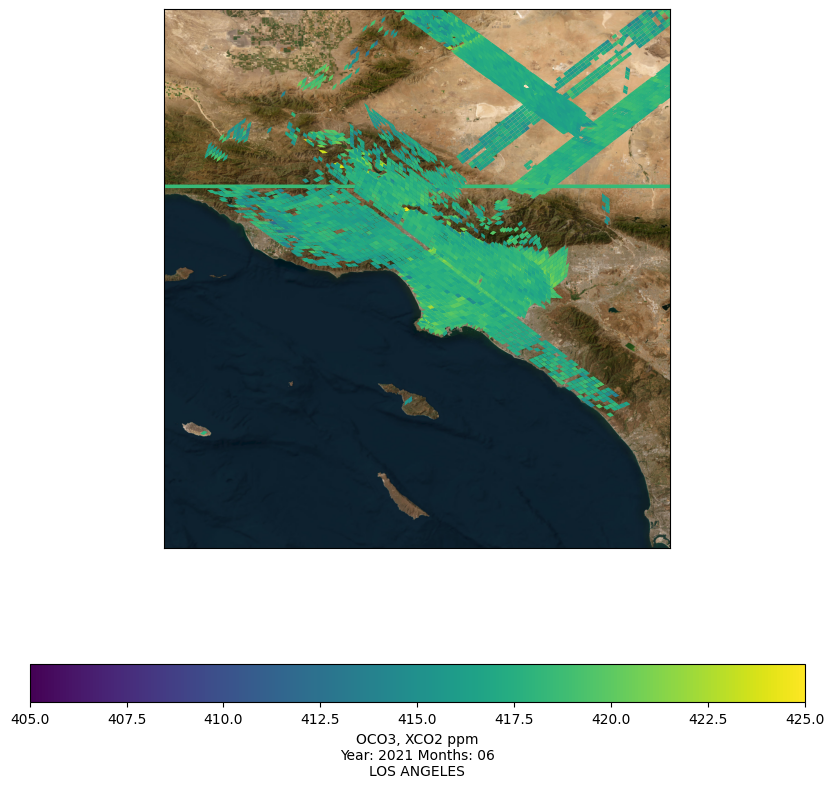

CPU times: user 8.53 s, sys: 207 ms, total: 8.73 s
Wall time: 21.6 s


In [21]:
%%time
## For an urban location, enter a city, i.e., "san francisco" (without quotes) then hit RETURN
location= input("Enter the location: ")
geo_loc= Nominatim(user_agent="locate", timeout=4)

info= geo_loc.geocode(str(location)).raw

## get the Bounding box information
loc_bbx= info["boundingbox"]
bbx_list= [float(i) for i in loc_bbx]
print('\n************************************\n')
print("Bbox information of :\n"+f'{location}')
bbx_list


# plot the location
plot_vertices(xco2_total, patches_total, bbx_list, location, year, month)

 ## 10. Plot the data values as a scatter plot

In [19]:
# # plot the location
# plot_vertices(xco2_total, patches_total, bbx_list, location year, month)

### Show the plot for the input month

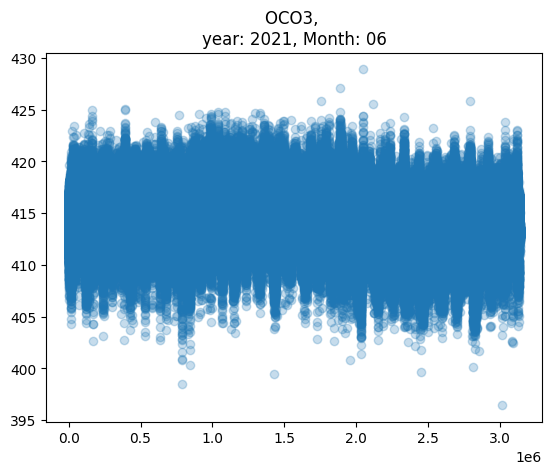

In [20]:
# plt.figure(figsize=(20,6))
plt.scatter(np.arange(0, len(xco2_total)), xco2_total, alpha= 0.25)
plt.title('OCO3, '+'\nyear: '+str(year) +', Month: '+ str(month));

### Show the plot for the input year

In [ ]:
plt.figure(figsize=(20,6))
plt.scatter(np.arange(0, len(xco2_total)), xco2_total, alpha= 1.0)
plt.title('OCO3, '+'\nyear: '+str(year));